In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path("../../../").resolve()))

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from ball_model.data import iter_traj, get_data, MEAS_DT
from ball_model.utils.plotting import MplUtils, setup_trajectory_axes, setup_board_axis

from IPython.core.display import HTML
style = """
<style>
div.output_area {
    overflow-y: scroll;
}
div.output_area img {
    max-width: unset;
}
</style>
"""
HTML(style)

MplUtils.set_style(plt, "l4dc")

## Display all trajectories from different launcher positions

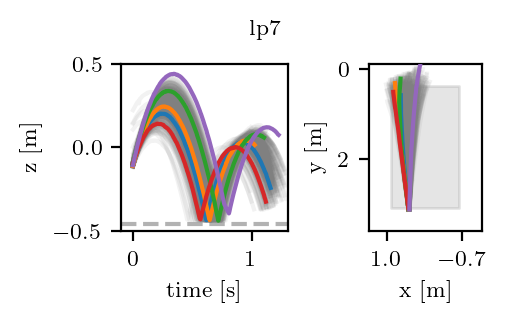

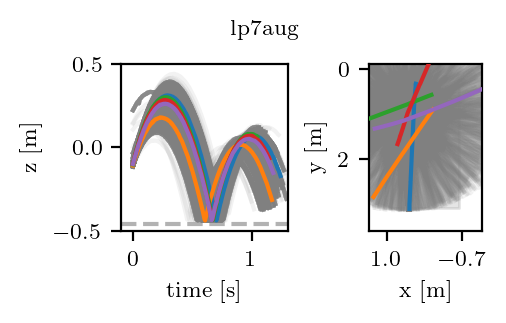

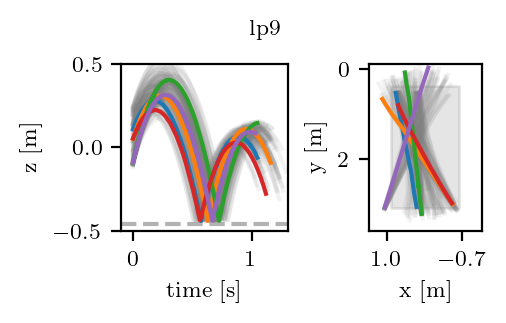

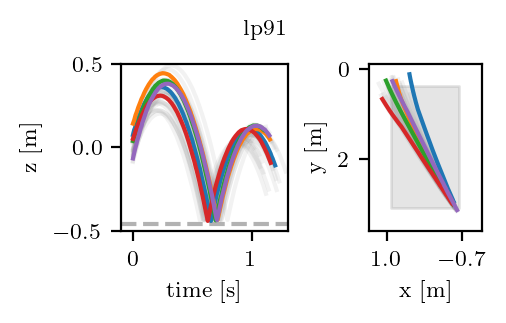

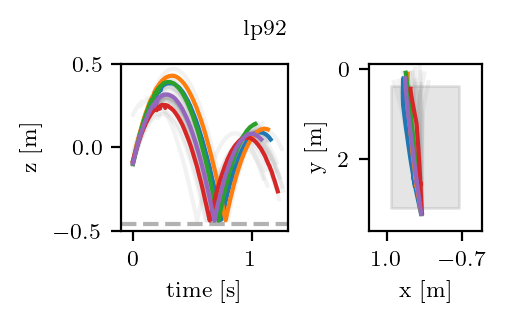

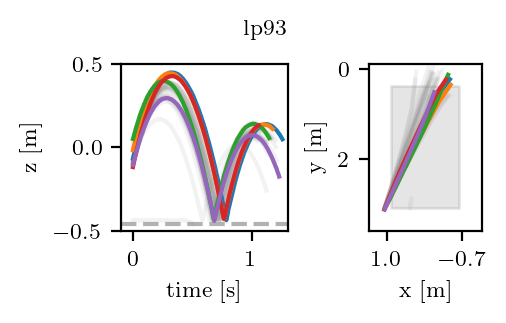

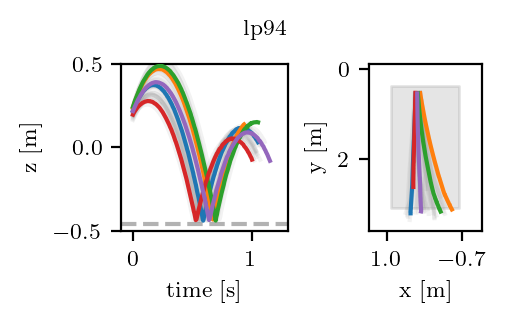

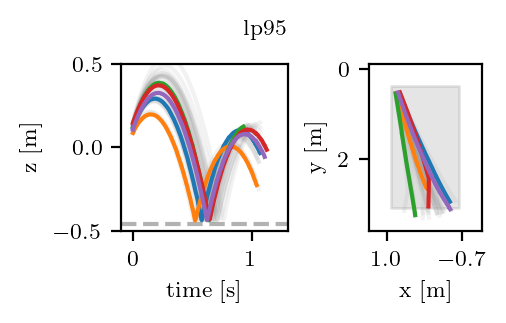

In [2]:
import random
random.seed(42)

launcher_pos_list = [
    "lp7",
    "lp7aug",
    "lp9",
    "lp91",
    "lp92",
    "lp93",
    "lp94",
    "lp95",
]

highlight = {
}

subsample = {
}

for launcher_pos in launcher_pos_list:
    fig, ax_arr = plt.subplots(
        nrows=1, ncols=2,
        constrained_layout=True,
        figsize=(MplUtils.get_width(0.5, 2), 1.5), squeeze=False
    )

    all_traj_names = [f for f,_ in iter_traj(launcher_pos, split_name="all")]
    random.shuffle(all_traj_names)

    subsample_pos = subsample[launcher_pos] if launcher_pos in subsample else 0
    if subsample_pos> 0:
        subsample_set = all_traj_names[:subsample_pos]
    else:
        subsample_set = all_traj_names

    highlight_pos = highlight[launcher_pos] if launcher_pos in highlight else 5

    highlight_set = subsample_set[:highlight_pos]

    for filename in subsample_set:
        if filename in highlight_set:
            plot_opts = dict(alpha=1, zorder=10)
        else:
            plot_opts = dict(alpha=0.1, color="gray", zorder=1)
        trajectory = get_data(filename)
        timestamps, positions = trajectory.timestamps, trajectory.positions
        ax_arr[0, 0].plot(timestamps, positions[:, 2], **plot_opts)
        ax_arr[0, 1].plot(positions[:, 0], positions[:, 1], **plot_opts)
        ax_arr[0, 1].set_aspect('equal')

    setup_trajectory_axes(ax_arr[0])
    fig.suptitle(launcher_pos)
    plt.savefig(f"graphics/visualization_{launcher_pos}.png", bbox_inches="tight", pad_inches=0)

In [3]:
split_counts = {k:{
    "train": 0,
    "val": 0,
    "test": 0,
    "total": 0
} for k in ["lp7", "lp9", "lp91", "lp92", "lp93", "lp94", "lp95"]}
for data_group in split_counts.keys():
    for _, split in iter_traj(data_group, split_name="all"):
        split_counts[data_group][split] += 1
        split_counts[data_group]["total"] += 1

print(split_counts)

{'lp7': {'train': 108, 'val': 63, 'test': 163, 'total': 334}, 'lp9': {'train': 0, 'val': 0, 'test': 150, 'total': 150}, 'lp91': {'train': 0, 'val': 0, 'test': 30, 'total': 30}, 'lp92': {'train': 0, 'val': 0, 'test': 30, 'total': 30}, 'lp93': {'train': 0, 'val': 0, 'test': 30, 'total': 30}, 'lp94': {'train': 0, 'val': 0, 'test': 30, 'total': 30}, 'lp95': {'train': 0, 'val': 0, 'test': 30, 'total': 30}}


In [4]:
# Visualize initial launcher positions (train / unseen); train: blue, unseen: orange (MPL palette)

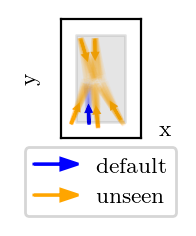

In [5]:
fig, ax = plt.subplots(
    nrows=1, ncols=1,
    constrained_layout=True,
    figsize=(2, 1)
)

# for visualization purposes, get most centered trajectory (for arrow)
center_trajectories = {}
for data_group in ["lp7", "lp91", "lp92", "lp93", "lp94", "lp95"]:
    closest_to_straight = (None, 1000)
    for traj_name, _ in iter_traj(data_group, split_name="all"):
        trajectory = get_data(traj_name)
        phi = trajectory.side_info[2]
        if np.abs(phi-0.5) < closest_to_straight[1]:
            closest_to_straight = (traj_name, np.abs(phi-0.5))
    center_trajectories[data_group] = closest_to_straight[0]


for traj_name in iter_traj("lp7", split_name="train"):
    traj = get_data(traj_name)
    ax.plot(traj.positions[:60, 0], traj.positions[:60, 1], color="blue", alpha=0.005)

lp7_center = get_data(center_trajectories["lp7"])
artists = []
labels = []
arrow = ax.arrow(
    lp7_center.positions[0, 0],
    lp7_center.positions[0, 1],
    lp7_center.positions[20, 0]-lp7_center.positions[0, 0],
    lp7_center.positions[20, 1]-lp7_center.positions[0, 1],
    head_width=0.15, head_length=0.15, fc='blue', ec='blue'
)
artists.append(arrow)
labels.append("default")

for traj_name in iter_traj("lp9", split_name="test"):
    traj = get_data(traj_name)
    ax.plot(traj.positions[:60, 0], traj.positions[:60, 1], color="orange", alpha=0.05)

for data_group in ["lp91", "lp92", "lp93", "lp94", "lp95"]:
    center = get_data(center_trajectories[data_group])

    arrow = ax.arrow(
        center.positions[0, 0],
        center.positions[0, 1],
        center.positions[20, 0]-center.positions[0, 0],
        center.positions[20, 1]-center.positions[0, 1],
        head_width=0.15, head_length=0.15, fc='orange', ec='orange'
    )
    if data_group == "lp91":
        artists.append(arrow)
        labels.append("unseen")

setup_board_axis(ax)

from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height )
    return p

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.legend(
    artists, labels, handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},
    loc="lower center", ncol=1, bbox_to_anchor=(0.5, -0.75)
)
ax.set_aspect('equal')
ax.xaxis.set_label_coords(1.3, 0.15)
plt.savefig("graphics/visualization_launch_dirs_topview.png", bbox_inches="tight")

## Check correlation of launch angle and launcher setting

In [6]:
rpm_v2_offset = {
    "rpm_tl": [297, 896, 1316, 1726, 2180, 2445, 2735, 3005, 3178, 3337,
        3508, 3654, 3826, 3856, 3917, 4123, 4337, 4575, 4614, 4615],
    "rpm_tr": [0, 476, 955, 1385, 1864, 2207, 2457, 2716, 2975, 3150,
        3332, 3518, 3642, 3739, 3851, 3960, 4060, 4198, 4433, 4596],
    "rpm_bc": [0, 517, 1077, 1594, 2055, 2515, 2851, 3091, 3387, 3572,
        3757, 3930, 4060, 4278, 4535, 4816, 4959, 4960, 4961, 4962],
    "actuation": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
        0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
}


rot_z_deg = -56.08558569861544*phi + -60.094624032259446
rot_x_deg = theta <= 0.8740863280312021: -32.82521212632685*theta + 81.98843931100635, else 53.29637017666002


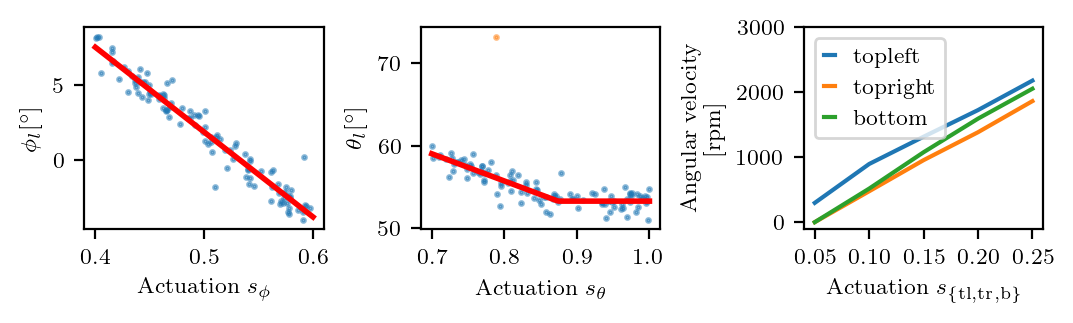

In [7]:
trajectories = []
for filename in iter_traj("lp7", split_name="train"):
    trajectory = get_data(filename)
    trajectories.append(trajectory)

rot_z_angles = []
rot_x_angles = []
phi_values = []
theta_values = []
for trajectory in trajectories:
    positions = trajectory.positions
    initial_vel = np.mean(positions[9:10, :], axis=0) - np.mean(positions[0:1, :], axis=0)
    rot_z_angle = np.arctan2(initial_vel[1], initial_vel[0]) # atan2(y/x)
    r = np.sqrt(initial_vel[0]**2+initial_vel[1]**2+initial_vel[2]**2)
    rot_x_angle = np.arccos(initial_vel[2]/r)
    rot_z_angles.append(180*rot_z_angle/np.pi)
    rot_x_angles.append(180*rot_x_angle/np.pi)
    phi_values.append(trajectory.side_info[2])
    theta_values.append(trajectory.side_info[3])

rot_z_angles = np.array(rot_z_angles)
rot_x_angles = np.array(rot_x_angles)
phi_values = np.array(phi_values)
theta_values = np.array(theta_values)

theta_outliers = theta_values[rot_x_angles > 65]
rot_x_outliers = rot_x_angles[rot_x_angles > 65]
theta_values = theta_values[rot_x_angles <= 65]
rot_x_angles = rot_x_angles[rot_x_angles <= 65]

from scipy.stats import linregress

# Linear regression of x/y angle
slope_phi, intercept_phi, _, _, _ = linregress(phi_values, rot_z_angles)
phi_fun = lambda x: x*slope_phi+intercept_phi

# Piecewise regression for z/y angle
slope_theta_1, intercept_theta_1, _, _, _ = linregress(theta_values[theta_values < 0.85], rot_x_angles[theta_values < 0.85])
slope_theta_2 = 0
intercept_theta_2 = np.mean(rot_x_angles[theta_values > 0.9])
theta_1_fun = lambda x: x*slope_theta+intercept_theta
theta_2_fun = lambda x: x*slope_theta_2+intercept_theta_2
theta_switch = (intercept_theta_2 - intercept_theta_1) / slope_theta_1
theta_fun = lambda x: ((x < theta_switch) * (slope_theta_1*x+intercept_theta_1) + ((x >= theta_switch) * intercept_theta_2))

fig, ax = plt.subplots(
    nrows=1, ncols=3,
    constrained_layout=True,
    figsize=(MplUtils.get_width(), 1.5),
)
ax[0].scatter(phi_values, rot_z_angles + 90, alpha=0.5, s=2)
phi_range = np.linspace(0.4, 0.6, 100)
ax[0].plot(phi_range, phi_fun(phi_range) + 90, color="r", linewidth=2)
ax[1].scatter(theta_values, rot_x_angles, alpha=0.5, s=2)
ax[1].scatter(theta_outliers, rot_x_outliers, alpha=0.5, s=2)

theta_range = np.linspace(0.7, 1, 100)
ax[1].plot(theta_range, theta_fun(theta_range), color="r", linewidth=2)

#ax[0].set_ylabel("$\\phi [{}^\\circ]$ \n(- right, -90°: straight, + left)")
ax[0].set_xlabel(r"Actuation $s_{\phi}$")
#ax[1].set_ylabel("$\\theta [{}^\\circ]$ \n(+ down, 90°: straight, - up)")
ax[1].set_xlabel(r"Actuation $s_{\theta}$")

ax[0].set_ylabel("$\\phi_l [{}^\\circ]$")
ax[1].set_ylabel("$\\theta_l [{}^\\circ]$")

ax[0].set_xticks([0.4, 0.5, 0.6])
ax[1].set_xticks([0.7, 0.8, 0.9, 1.0])

ax[2].plot(np.array(rpm_v2_offset["actuation"][:5]), np.array(rpm_v2_offset["rpm_tl"][:5]), label="topleft")
ax[2].plot(np.array(rpm_v2_offset["actuation"][:5]), np.array(rpm_v2_offset["rpm_tr"][:5]), label="topright")
ax[2].plot(np.array(rpm_v2_offset["actuation"][:5]), np.array(rpm_v2_offset["rpm_bc"][:5]), label="bottom")
ax[2].set_xticks(np.array(rpm_v2_offset["actuation"][:5]))
ax[2].set_ylabel("Angular velocity \n [rpm]")
ax[2].set_xlabel("Actuation $s_{\{\mathrm{tl}, \mathrm{tr}, \mathrm{b}\}}$")
ax[2].legend(loc="upper left", handlelength=0.5, fontsize=8)
ax[2].set_ylim(-100, 3000)

# The following values are to be used in ball_model/data/rotations.py
print(f"rot_z_deg = {slope_phi}*phi + {intercept_phi}")
print(f"rot_x_deg = theta <= {theta_switch}: {slope_theta_1}*theta + {intercept_theta_1}, else {intercept_theta_2}")

plt.savefig("graphics/visualization_s_theta_phi.png", bbox_inches="tight", pad_inches=0)